In [4]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

with nc.Dataset('/Users/mgrecu/WDomains/MCS_OK/wrfout_d03_2018-06-25_04:00:00') as f:
    rain = f.variables['RAINNC'][:]
    dbz=f.variables['REFL_10CM'][:]
    height=(f.variables['PH'][:]+f.variables['PHB'][:])/9.81
    lon=f.variables['XLONG'][:]
    lat=f.variables['XLAT'][:]
    qr=f.variables['QRAIN'][:]
    ncrain=f.variables['QNRAIN'][:]
    qgraup=f.variables['QGRAUP'][:]
    ncgraup=f.variables['QNGRAUPEL'][:]
    qsn=f.variables['QSNOW'][:]
    #qhail=f.variables['QHAIL'][:]
    #ncsn=f.variables['QNSNOW'][:]

KeyError: 'QHAIL'

(189, 201) (189, 201) (83, 189, 201)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


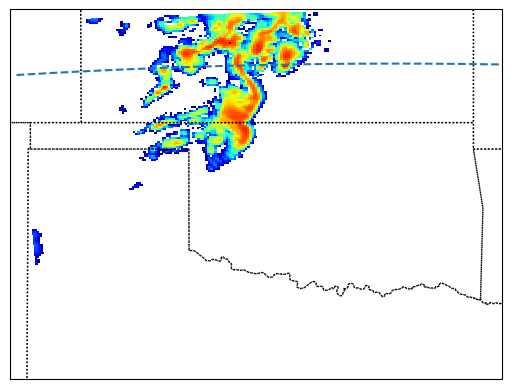

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
print(lon[0].shape, lat[0].shape, dbz[0].shape)
dbzm=np.ma.masked_where(dbz[:,:,:,:]<10, dbz[:,:,:,:])
plt.pcolormesh(lon[0,:,:], lat[0,:,:], dbzm[0,0,:,:], vmin=10, vmax=60, cmap='jet')
plt.plot(lon[0,160,:], lat[0,160,:], '--')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')


(4, 189, 201)
(4, 84, 189, 201)
(83, 201)
(201,)
(84,)


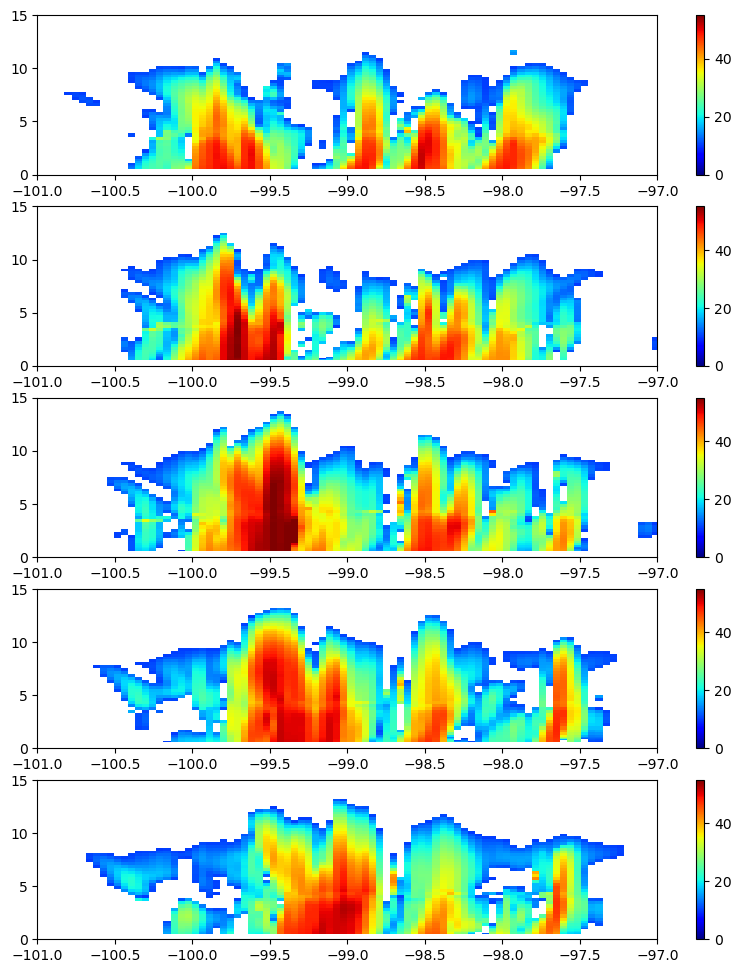

In [43]:
print(lon.shape)
print(height.shape)
print(dbzm[0,:,160,:].shape)
print(lon[0,160,:].shape)
print(height[0,:,160,100].shape)
plt.figure(figsize=(10,12))
for i in range(5,10):
    plt.subplot(5,1,i-5+1)
    plt.pcolormesh(lon[0,160,:],height[0,:-1,155+2*i,100]/1e3,dbzm[1,:,158+2*i,:], cmap='jet',vmin=0, vmax=55)
    plt.colorbar()
    plt.xlim(-101, -97)
    plt.ylim(0, 15)

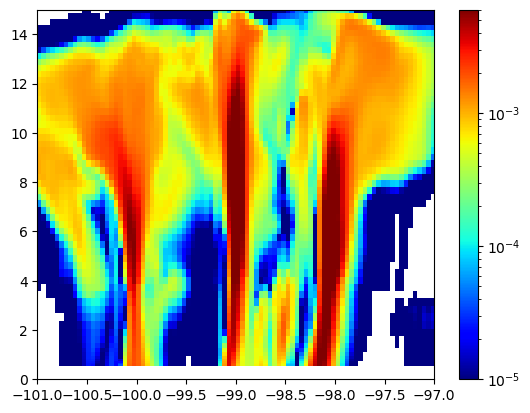

In [12]:
import lkTables
lkTables=lkTables.scattTables() 
from bisectm import bisectm
qt=qr+1*qsn+qgraup
for iy in range(5,6):
    plt.subplot(1,1,i-5+1)
    plt.pcolormesh(lon[0,160,:],height[0,:-1,155+2*iy,100]/1e3,qt[0,:,155+2*iy,:], cmap='jet',norm=colors.LogNorm(vmin=1e-5, vmax=6e-3))
    plt.colorbar()
    plt.xlim(-101, -97)
    plt.ylim(0, 15)